In [1]:
from netCDF4 import Dataset

# This notebook finds the nearest parcel to Polarstern's initial position

### Set up pointers to the netcdf data

Don't worry about memory in the next cell, calling Dataset doesn't load all the data into memory

In [2]:
snod_nc = Dataset('raw_data/snod_p.nc')
sden_nc = Dataset('raw_data/sden_p.nc')
ij_nc = Dataset('raw_data/ij_p.nc')

### Wrangle the data a bit to get the i, j coords and the snow depth and density for each parcel

### The netcdf dimensions are a bit screwed up, but this sorts it out so everything's the right shape and 2D

In [3]:
snod_full = snod_nc['snod'][:,0,:]
sden_full = sden_nc['sden'][:,0,:]
i_full   = ij_nc['ii'][:,0,:]
j_full   = ij_nc['jj'][:,0,:]


(snod_full.shape, sden_full.shape, i_full.shape, j_full.shape)

((731, 70000), (731, 70000), (731, 70000), (731, 70000))

### The array is 731 days long because 2020 was a leap year (365 + 366 = 731).

### So we could split all these data into two years: 2018-19 & 2019-20. But let's just grab 2019-20 for now as that's what we're interested in.

In [5]:
snod = snod_full[-366:,:]
sden = sden_full[-366:,:]
i_co = i_full[-366:,:]
j_co = j_full[-366:,:]

 A tricky point about the tracks file. If a parcel is created on (say) 3rd Jan 2020, in the tracks file its position is listed as that for every day prior (because the tracks file is just a big table where each column is a track). 
 
Similarly when the track stops having the model run on it, it just holds its position until the model run is up. We'd like these to be nans as well.

We'll soon be looking for the nearest track to the PolarStern position. We need a way of telling if a track is "active", as we don't want to ID a dormant track. We do this by setting the coords to nans. 
 
The following cell fixes this, by setting the position of the track to np.nan before its creation and after its demise. 

Doing this takes a few minutes as there are a lot of tracks. Specifically it took my home PC ~4 mins

In [7]:
import tqdm
import numpy as np

for ind in tqdm.trange(i_co.shape[1]):
    
    i_co[:,ind] = [np.nan if x in [i_co[0,ind], i_co[-1,ind]] else x for x in i_co[:,ind]]
    j_co[:,ind] = [np.nan if x in [j_co[0,ind], j_co[-1,ind]] else x for x in j_co[:,ind]]

100%|██████████| 70000/70000 [04:36<00:00, 253.22it/s]


### Let's make a date index for these data

In [8]:
import datetime

t0 = datetime.date(year=2019,month=8,day=1)

SM_dates = [t0 + datetime.timedelta(days=x) for x in range(366)]

# Now process Polarstern position data

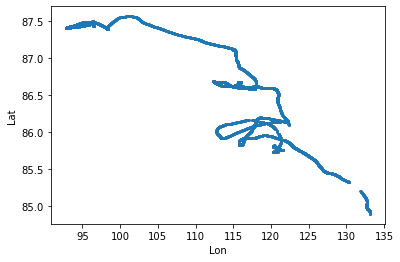

,tower_lat,tower_lon,date/Time,dt
0,84.894152,133.164124,2019-10-19 0:00,2019-10-19 00:00:00
1,84.895235,133.161979,2019-10-19 0:10,2019-10-19 00:10:00
2,84.896317,133.159474,2019-10-19 0:20,2019-10-19 00:20:00
3,84.897400,133.156768,2019-10-19 0:30,2019-10-19 00:30:00
4,84.898485,133.153794,2019-10-19 0:40,2019-10-19 00:40:00
...,...,...,...,...
15115,87.493601,96.353931,2020-01-31 23:10,2020-01-31 23:10:00
15116,87.493700,96.355273,2020-01-31 23:20,2020-01-31 23:20:00
15117,87.493794,96.356634,2020-01-31 23:30,2020-01-31 23:30:00
15118,87.493877,96.357996,2020-01-31 23:40,2020-01-31 23:40:00


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

file = 'Polarstern_track.csv'
df = pd.read_csv(file)

df['dt'] = [datetime.datetime.strptime(x, '%Y-%m-%d %H:%M') for x in df['date/Time']]

plt.scatter(df['tower_lon'], df['tower_lat'],s=2)
plt.xlabel('Lon'); plt.ylabel('Lat')
plt.show()

df

### Get first available PS location

In [10]:
lon0, lat0, dt0 = df['tower_lon'].iloc[0], df['tower_lat'].iloc[0], df['dt'].iloc[0]

(lon0,lat0,dt0)

(133.1641238, 84.89415245, Timestamp('2019-10-19 00:00:00'))

### Now go back to the SM data and get the positions of all the parcels on that date

[199.00002       nan       nan ...       nan       nan       nan] [nan nan nan ... nan nan nan]


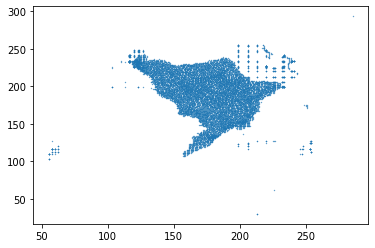

In [11]:
# This gets the index of the date in the list_of_dates

ind_0 = SM_dates.index(dt0)

# Now get all the i and j coords on the first date of the PS track using that index

i_on_date = i_co[ind_0]
j_on_date = j_co[ind_0]

print(i_on_date, j_on_date)

# Plot all these coordinates

plt.scatter(i_on_date,j_on_date, s=0.1)

### What is this bizarre coordinate system? All values range between 0 - 361 on the i and j axes

### Looks like it corresponds to the 361x361 EASE grid (but I've never seen this format before).

In [12]:
from ll_xy import lonlat_to_xy

# Get the EASE coordinates

mymask = Dataset('mask.nc')
ease_lons = np.array(mymask['lon'])
ease_lats = np.array(mymask['lat'])

# This gets the ease coordinates in meters as defined by EPSG 3408

ease_x, ease_y = lonlat_to_xy(ease_lons, ease_lats, hemisphere='n')

In [13]:
# The corners of the EASE grid define a square
# This is shown by printing the x and y coordinates of each of its four corners
print(ease_x[0,0], ease_x[0,-1],  ease_x[-1,0], ease_x[-1,-1])
print(ease_y[0,0], ease_y[0,-1],  ease_y[-1,0], ease_y[-1,-1])

-4512154.440396543 4512154.440396538 -4512154.440396539 4512154.440396539
-4512154.440396534 -4512154.440396539 4512154.440396538 4512154.440396538


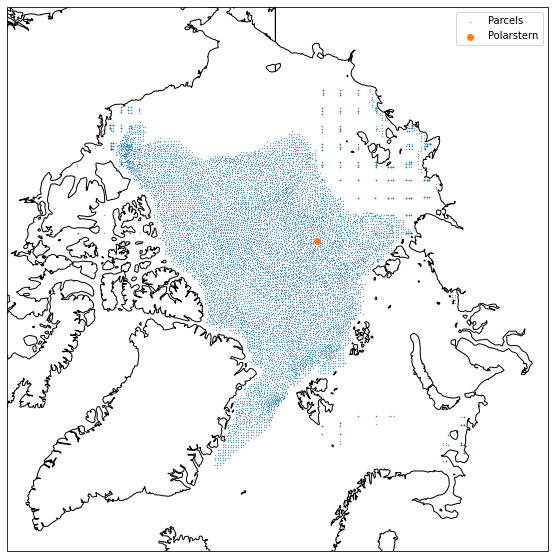

In [14]:
#  We'll assume that i=0,j=0 corresponds to the lower left coordinate 
#  And i = 361 & j = 361 corresponds to the upper right coord

i_on_date = np.ma.masked_where(i_on_date == 1, i_on_date)
j_on_date = np.ma.masked_where(j_on_date == 1, j_on_date)
i_on_date = np.ma.filled(i_on_date,np.nan)
j_on_date = np.ma.filled(j_on_date,np.nan)

def convert_361_coords_to_ease(data,ease_x):
    data_ease = (data/361) * (2*ease_x[0,-1]) - ease_x[0,-1]
    return data_ease

i_on_date_ease = convert_361_coords_to_ease(i_on_date,ease_x)
j_on_date_ease = convert_361_coords_to_ease(j_on_date,ease_x)

lons_on_date, lats_on_date = lonlat_to_xy(i_on_date_ease, j_on_date_ease, hemisphere='n', inverse= True)

# Plot parcel distribution

import cartopy
import cartopy.crs as ccrs

fig = plt.figure(figsize=(10,10))  
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 90, 66], ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1,facecolor='None')
ax.scatter(lons_on_date,lats_on_date, transform=ccrs.PlateCarree(),s=0.1,label='Parcels')

# Plot Polarstern with Orange Dot

ax.scatter(lon0,lat0, transform=ccrs.PlateCarree(),label='Polarstern')

plt.legend()
# Seems like an exact fit!

### So we now have two arrays for the x and y coordinates of all the parcels active on the day that PS starts its drift.

### Task now is to find the nearest one. To do this we can use a kdtree

In [15]:
from scipy.spatial import KDTree

In [16]:
# i_no_nans = i_on_date_ease[~np.isnan(i_on_date_ease)]
# j_no_nans = i_on_date_ease[~np.isnan(j_on_date_ease)]

# i_no_nans_ind = ~np.isnan(i_no_nans)
# j_no_nans_ind = ~np.isnan(j_no_nans)

(9990.721080822803, 3435)


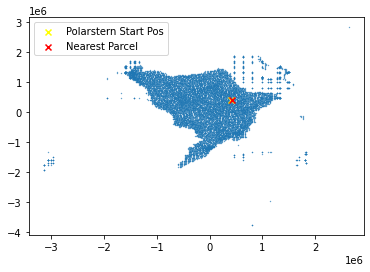

In [17]:
tree = KDTree(list(zip(i_on_date_ease, j_on_date_ease)),
              leafsize=1000000,
             )

x0,y0 = lonlat_to_xy([lon0],[lat0],hemisphere='n')

tree_output = tree.query([x0[0],y0[0]])

print(tree_output)

plt.scatter(i_on_date_ease,j_on_date_ease,s=0.1)
plt.scatter(x0[0],y0[0],color='yellow',marker='x',label='Polarstern Start Pos')
plt.scatter(i_on_date_ease[tree_output[1]],j_on_date_ease[tree_output[1]],color='red',marker='x',label='Nearest Parcel')
plt.legend()

### So there is a parcel 9.9 km away from the PS initialisation point. It has index 3435

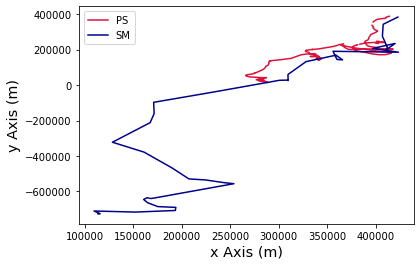

In [18]:
PS_parcel_i = convert_361_coords_to_ease(i_co,ease_x)
PS_parcel_j = convert_361_coords_to_ease(j_co,ease_x)

i_track = PS_parcel_i[:,tree_output[1]]
j_track = PS_parcel_j[:,tree_output[1]]

PS_lats = np.array(df['tower_lat']); PS_lons = np.array(df['tower_lon'])

PSx, PSy = lonlat_to_xy(PS_lons, PS_lats, hemisphere='n')

plt.plot(PSx,PSy,color='crimson',label='PS')
plt.plot(i_track[ind_0:], j_track[ind_0:],color='darkblue',label='SM')
plt.xlabel('x Axis (m)',fontsize='x-large')
plt.ylabel('y Axis (m)',fontsize='x-large')
plt.legend()

Text(0.5, 0, 'Date')

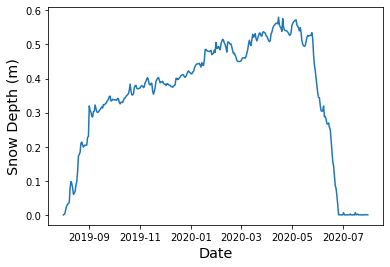

In [22]:
snow_depth = snod[:,tree_output[1]]
plt.plot(SM_dates,snow_depth)
plt.ylabel('Snow Depth (m)', fontsize='x-large')
plt.xlabel('Date', fontsize='x-large')

Text(0.5, 0, 'Date')

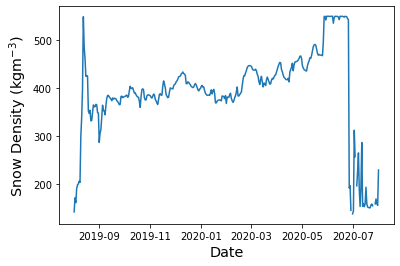

In [23]:
snow_density = sden[:,tree_output[1]]
plt.plot(SM_dates,snow_density)
plt.ylabel(r'Snow Density (kgm$^{-3}$)', fontsize='x-large')
plt.xlabel('Date', fontsize='x-large')

In [25]:
output_df = pd.DataFrame({'Date':SM_dates,
                                 'Depth':snow_depth,
                                 'Density':snow_density})

output_df

,Date,Depth,Density
0,2019-08-01,0.000000,NaN
1,2019-08-02,0.001880,141.553085
2,2019-08-03,0.005871,170.851196
3,2019-08-04,0.018424,160.790253
4,2019-08-05,0.026992,189.889420
...,...,...,...
361,2020-07-27,0.000089,158.117462
362,2020-07-28,0.001202,168.481354
363,2020-07-29,0.000228,158.800003
364,2020-07-30,0.000599,155.203979


In [281]:
output_df.to_csv('Output.csv',index=False)

# Plotting the data with nice ticks

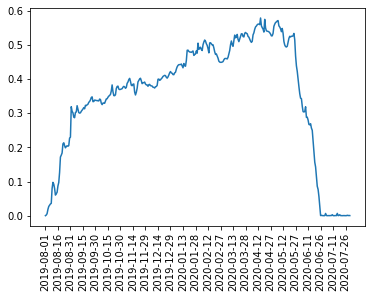

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('Output.csv')

plt.plot(df.Date, df.Depth)

# generally better to call pandas columns like this:
# plt.plot(df['Date'], df['Depth'])

plt.xticks(df.Date[::15],rotation=90)
plt.show()

# Plotting magnaprobe data on top:

In [ ]:
# First I'll make some synthetic magnaprobe data

d0 
dates = []

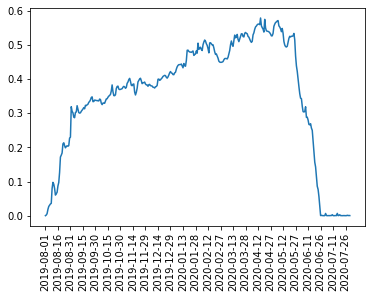

In [17]:
plt.plot(df.Date, df.Depth)

plt.xticks(df.Date[::15],rotation=90)
plt.show()

In [9]:


plt.plot(df['Date'],df['Depth'])

KeyError: "None of ['Date'] are in the columns"